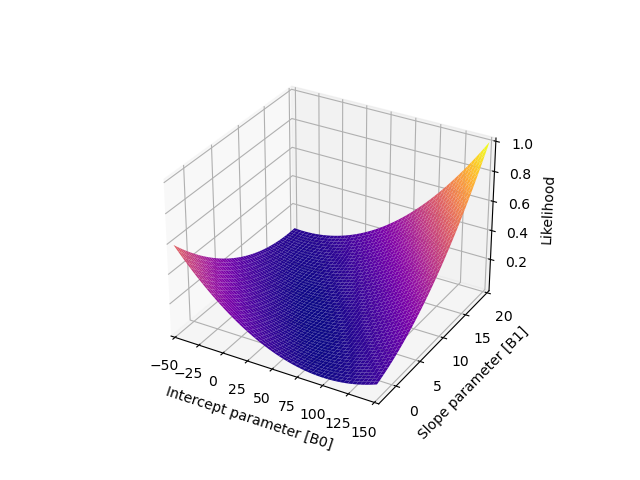

Intercept approximation: 49.677840504987024
Slope approximation 5.016528877877368

Actual [better] intercept and slope approx:
Intercept:  49.67777777777776
Coefficient:  [5.01666667]


In [1]:
####Working version
###Notes
##1) This is done specifically for models following a Gaussian distribution, with a ~known (approximated) standard deviation, unknown intercept and 1 coefficient for a covariate.
##2) Both the log likelihood and "true" likelihood are well optimised.

import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy.stats as stats
from math import sqrt, pi, e, log10
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import ipympl
from mpl_toolkits import mplot3d ###makes 3d plots interactive!

#df = pd.read_csv('csv_file')

#nutri_df = pd.read_csv('csv_file')
nutri_df = nutri_df.rename(columns={'Body_Mass_Index': 'BMI', 'Arm_Circumference_in_Centimeters': 'Arm_Circumference'})
nutri_df = nutri_df.dropna()
nutri_df = nutri_df.reset_index()

def JointDensity(x,y,beta1,beta0,StdDev, loglik = True):
    ##Change iteration with np.multiply to speed it up
    ##Use log-likelihoods to better see small differences (high multiplications lead to extremely low values)
    ##Add dials to change the noise (variance) of parameters. By now, this can be done artificially by reducing sample size from the data (rows) selected

    beta0,beta1 = np.meshgrid(beta0,beta1)
    ysum = np.sum(y)
    xsum = np.sum(x)
    n = len(x)

    L = np.sum(-y**2) + 2*beta0*ysum + 2*beta1*(np.sum(x*y)) - n*beta0**2 - 2*beta0*beta1*xsum - beta1**2*(np.sum(x**2))

    if loglik:
        L = L * np.log(e/(StdDev*sqrt(2*pi)))/(2*StdDev**2)

        #normalize humongous values
        L = L / np.max(L)

        thresh = np.min(L)*1.25
        crest = L <= thresh

    else:
        # denom = (StdDev*sqrt(2*pi))**len(x) 
        ##dropped the denominator as it does not change the shape of the slope, only the peak value of the likelihood
        
        L = L / (2*StdDev**2)
        L = np.exp(L) #/denom ### drop denominator

        thresh = np.max(L)*0.955
        crest = L >= thresh

    beta0_approx = np.mean(beta0[crest])
    beta1_approx = np.mean(beta1[crest])

    return L,beta0,beta1, (beta0_approx, beta1_approx)

def PlotLikelihood(beta0_ax, beta1_ax, x,y, z, xlim,ylim, StdDev):

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.plot_surface(beta0_ax, beta1_ax, z, cmap=cm.plasma) ##beta0 = x_axis, beta1 = y_axis
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    # ax.view_init(azim=140, elev=15)
    ax.set(xlabel="Intercept parameter [B0]", ylabel="Slope parameter [B1]", zlabel="Likelihood")
    plt.show()

##EXAMPLE

x = np.array(df.Hours_Studied) ##some variable x
y = np.array(df.Test_Grade) ##some variable y

##set range of values of the x and y axes
xlim = (-50,150) 
ylim = (-3,20)
test_array_x = np.linspace(xlim[0],xlim[1],3_000) ###Last value represents meshgrid resolution
test_array_y = np.linspace(ylim[0],ylim[1],3_000)

std_dev = np.std(y)

LikelihoodVals,beta0_mesh,beta1_mesh, approximations = JointDensity(
    x = x, y = y, beta1=test_array_y, beta0=test_array_x, StdDev=std_dev, loglik=True)

PlotLikelihood(beta0_ax = beta0_mesh, beta1_ax = beta1_mesh, 
               x = x, y = y, z = LikelihoodVals,
               xlim = xlim, ylim = ylim, StdDev=std_dev)


print("Intercept approximation:", approximations[0])
print("Slope approximation", approximations[1])
print()
print("Actual [better] intercept and slope approx:")
lr = lm.LinearRegression()
lr.fit(x[:, np.newaxis], y)
print("Intercept: ", lr.intercept_)
print("Coefficient: ", lr.coef_)


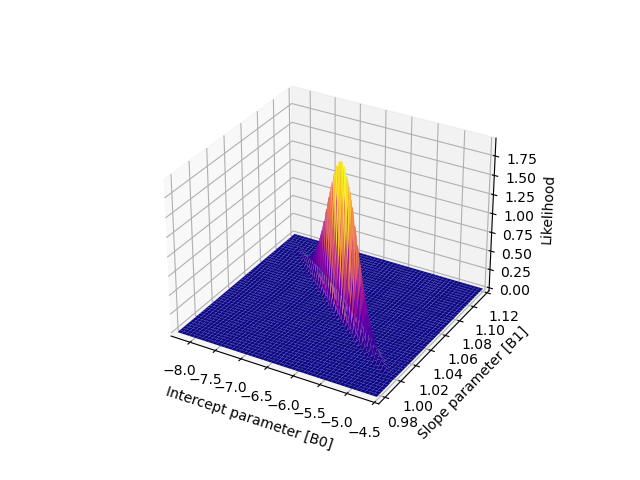

Intercept approximation: -6.266278628823988
Slope approximation 1.050090332398381

Actual better intercept and slope approx:
Intercept:  -6.266346425069749
Coefficient:  [1.05009213]


In [2]:
###Example: 
##Explain BMI with Arm circumference. Calculate slope and intercept.
##In this case, the ~"true" likelihood is calculated, not its log.
##The x- and y-limits have to be set to very small values because this plot, unlike the log, is very sensitive to small changes

x = np.array(nutri_df.Arm_Circumference)
y = np.array(nutri_df.BMI)

##set range of values of the x and y axes
xlim = (-8.3,-4.5) 
ylim = (0.975,1.12)
test_array_x = np.linspace(xlim[0],xlim[1],3_000) ###Last value represents meshgrid resolution
test_array_y = np.linspace(ylim[0],ylim[1],3_000)

std_dev = np.std(y)

LikelihoodVals,beta0_mesh,beta1_mesh, approximations = JointDensity(
    x = x, y = y, beta1=test_array_y, beta0=test_array_x, StdDev=std_dev, loglik=False)

PlotLikelihood(beta0_ax = beta0_mesh, beta1_ax = beta1_mesh, 
               x = x, y = y, z = LikelihoodVals,
               xlim = xlim, ylim = ylim, StdDev=std_dev)


print("Intercept approximation:", approximations[0])
print("Slope approximation", approximations[1])
print()
print("Actual better intercept and slope approx:")
lr = lm.LinearRegression()
lr.fit(x[:, np.newaxis], y)
print("Intercept: ", lr.intercept_)
print("Coefficient: ", lr.coef_)

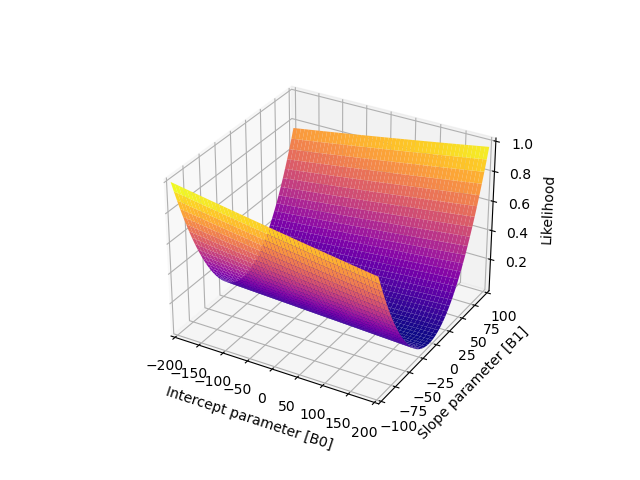

Intercept approximation: -6.180614983549284
Slope approximation 1.047668570176077

Actual better intercept and slope approx:
Intercept:  -6.266346425069749
Coefficient:  [1.05009213]


In [3]:
###Example: 
##Explain BMI with Arm circumference. Calculate slope and intercept. In this case, with the loglik.

x = np.array(nutri_df.Arm_Circumference)
y = np.array(nutri_df.BMI)

##set range of values of the x and y axes
xlim = (-200,200) 
ylim = (-100,100)
test_array_x = np.linspace(xlim[0],xlim[1],3_000) ###Last value represents meshgrid resolution
test_array_y = np.linspace(ylim[0],ylim[1],3_000)

std_dev = np.std(y)

LikelihoodVals,beta0_mesh,beta1_mesh, approximations = JointDensity(
    x = x, y = y, beta1=test_array_y, beta0=test_array_x, StdDev=std_dev, loglik=True)

PlotLikelihood(beta0_ax = beta0_mesh, beta1_ax = beta1_mesh, 
               x = x, y = y, z = LikelihoodVals,
               xlim = xlim, ylim = ylim, StdDev=std_dev)


print("Intercept approximation:", approximations[0])
print("Slope approximation", approximations[1])
print()
print("Actual better intercept and slope approx:")
lr = lm.LinearRegression()
lr.fit(x[:, np.newaxis], y)
print("Intercept: ", lr.intercept_)
print("Coefficient: ", lr.coef_)